In [66]:
# Generales
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re
# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Tensorflow y Keras
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 

In [67]:
def sanitize_tweet(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

In [68]:
texto = "Hola @usuario, visita http://example.com para más info! ;) #feliz #día"
print(sanitize_tweet(texto))

hola  visita  para ms info  feliz da


In [69]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 100    # Longitud prefijada de la reseña
D = 128  # Dimensión del embedding
EPOCHS = 20
NEURONAS = 128

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

path = "/kaggle/input/tweetsdata/tuits_desastres.csv"

datos = pd.read_csv(path)

In [70]:
datos.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [71]:
datos.drop(["id", "keyword", "location"], axis=1, inplace=True)

In [72]:
datos.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [73]:
# Unimos las preguntas
datos['text'] = datos['text'].apply(sanitize_tweet)

# Textos de entrada
textos = datos["text"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()
y = datos['target'].values

In [74]:
datos.head(50)

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1
5,rockyfire update california hwy 20 closed in ...,1
6,flood disaster heavy rain causes flash floodin...,1
7,im on top of the hill and i can see a fire in ...,1
8,theres an emergency evacuation happening now i...,1
9,im afraid that the tornado is coming to our area,1


In [75]:
X.shape

(7613, 100)

In [76]:
X.shape[1]

100

In [77]:
print(X.shape)
print(y.shape)

(7613, 100)
(7613,)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [79]:
earlystopping = EarlyStopping( 
    monitor='val_loss',  # Métrica a controlar 
    min_delta=0.001,     
    patience=5,         
    mode='min',          
    restore_best_weights=True # Restaurar los mejores pesos 
) 

lrScheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) 

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM, Dense, Dropout,
                                     GlobalMaxPooling1D, LayerNormalization)

model = Sequential([
    Input(shape=(T,)),
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.3)),
    Bidirectional(LSTM(units=32, dropout=0.3)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │       2,560,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,700,353 (10.30 MB)

 Trainable params: 2,700,353 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1, callbacks=[earlystopping])

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6249 - loss: 0.6261 - val_accuracy: 0.7824 - val_loss: 0.4707
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8862 - loss: 0.2939 - val_accuracy: 0.7709 - val_loss: 0.4934
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9391 - loss: 0.1912 - val_accuracy: 0.7644 - val_loss: 0.5542
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9682 - loss: 0.1106 - val_accuracy: 0.7685 - val_loss: 0.6688
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9770 - loss: 0.0811 - val_accuracy: 0.7693 - val_loss: 0.6832
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9778 - loss: 0.0681 - val_accuracy: 0.7529 - val_loss: 0.8956


In [82]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

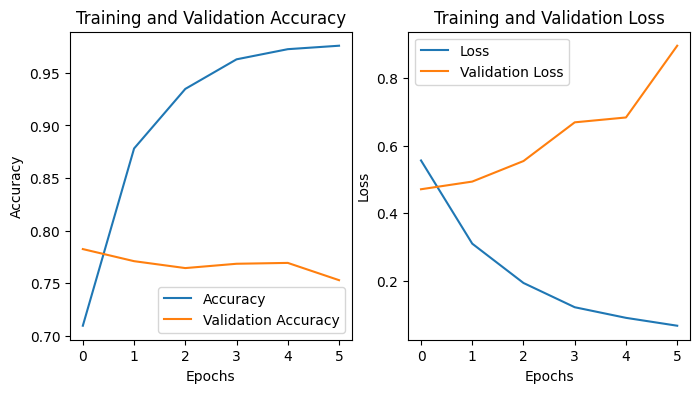

In [83]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

No Catástrofe       0.76      0.94      0.84       874
   Catástrofe       0.88      0.61      0.72       649

     accuracy                           0.80      1523
    macro avg       0.82      0.77      0.78      1523
 weighted avg       0.81      0.80      0.79      1523



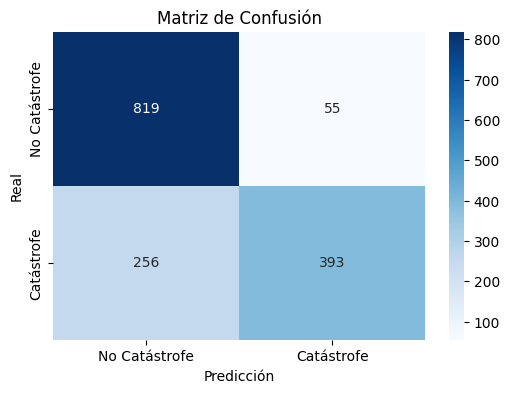

In [84]:
def train_validation(model, X_test, y_test):
   
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Catástrofe", "Catástrofe"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Catástrofe", "Catástrofe"],
                yticklabels=["No Catástrofe", "Catástrofe"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

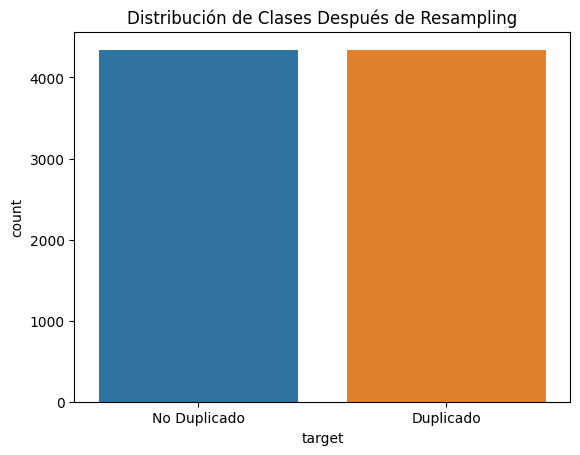

In [86]:
# Separar las clases
clase_mayoritaria = datos[datos['target'] == 0]
clase_minoritaria = datos[datos['target'] == 1]

# Hacer oversampling de la clase minoritaria
clase_minoritaria_aumentada = resample(
    clase_minoritaria,
    replace=True,                      # muestreo con reemplazo
    n_samples=len(clase_mayoritaria), # igualar al número de la clase mayoritaria
    random_state=42
)

# Combinar para tener un dataset balanceado
datos_balanceado = pd.concat([clase_mayoritaria, clase_minoritaria_aumentada])

# Barajar las filas
datos_balanceado = datos_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar nuevo balance
sns.countplot(data=datos_balanceado, x='target')
plt.title("Distribución de Clases Después de Resampling")
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()

In [87]:
datos_balanceado.head()

,text,target
0,i bet you didnt know i kick box too,0
1,22beyonce is my pick for fan army beyhive,0
2,the best thing about this is it drowned out th...,0
3,man cam just demolished his plate his ass was ...,0
4,heros fight wars and save ppl from burning bui...,0


In [88]:
textos = datos_balanceado["text"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()

# La variable objetivo
y = datos_balanceado["target"].values  # O la columna que estés usando como etiqueta

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [90]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 128)            │       2,560,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,258,881 (12.43 MB)

 Trainable params: 3,258,881 (12.43 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1, callbacks=[earlystopping])

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6496 - loss: 0.5975 - val_accuracy: 0.8129 - val_loss: 0.4201
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9096 - loss: 0.2454 - val_accuracy: 0.8295 - val_loss: 0.4169
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9584 - loss: 0.1225 - val_accuracy: 0.8295 - val_loss: 0.4489
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9759 - loss: 0.0718 - val_accuracy: 0.8367 - val_loss: 0.5197
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9791 - loss: 0.0471 - val_accuracy: 0.8281 - val_loss: 0.5113
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9802 - loss: 0.0424 - val_accuracy: 0.8331 - val_loss: 0.7938
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9770 - loss: 0.0489 - val_accuracy: 0.8180 - val_loss: 0.6606


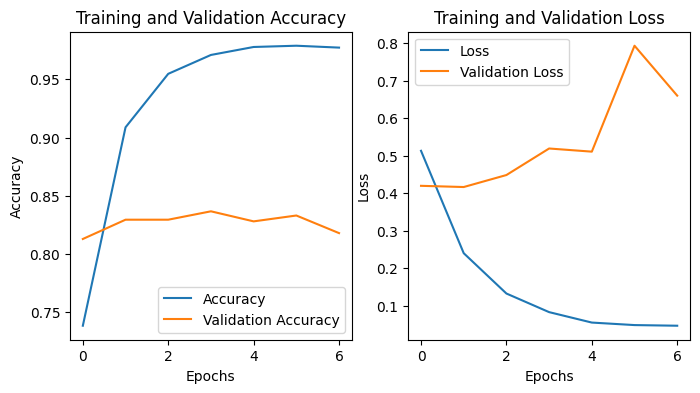

In [92]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

No Catástrofe       0.82      0.87      0.85       858
   Catástrofe       0.86      0.82      0.84       879

     accuracy                           0.84      1737
    macro avg       0.84      0.84      0.84      1737
 weighted avg       0.84      0.84      0.84      1737



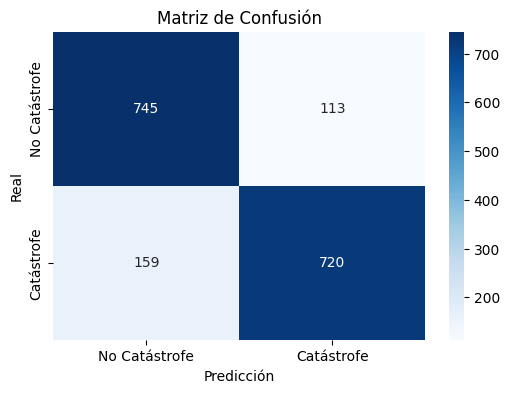

In [93]:
# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)